# Course Evaluation: Please fill out [this quick eval!](https://forms.office.com/Pages/ResponsePage.aspx?id=lYdfxj26UUOKBwhl5djwkFtIujJ9lCFMouysTWFV3rRURFZHRjFZUVc2QTlJNzJDMUdUWjhXN1dPMi4u)

# Rasterized Data

There are two primary forms of geospatial data: vectors and rasters. This notebook and its packages deal with **rasterized** data:
<img src='https://www.ordnancesurvey.co.uk/img-assets/media-components/06-Raster-Data.xbf666d6e.jpg?w=3840&f=webp' style='height:70%; width:50%;'>

Rasterized data is essentially a gridded format for data:
* Each **datapoint** is a **pixel**.
* Each **pixel** has a set of **coordinates** it belongs to.
* The **coordinates** can describe the **location** of the data (but can also include time dimensions).

<img src=https://docs.qgis.org/3.40/en/_images/raster_dataset.png style='height:70%; width:30%;'>

# The netCDF file format

The **[netCDF](https://www.unidata.ucar.edu/software/netcdf/)** file format is a popular scientific file format for ocean and atmosphere gridded datasets. It is a collection of formats storing arrays:

* **netCDF classic**
    * more widespread
    * 2 GB file limit (if you don't use the unlimited dimension)
    * often preferred for distributing products

* **netCDF 64 bit offset**
    * supports larger files

* **NetCDF4**
    * based on [HDF5](https://en.wikipedia.org/wiki/Hierarchical_Data_Format)
    * allows compression
    * multiple unlimited variables

netCDF was developed by Unidata-UCAR with the aim of storing climate model data, which is often 3D plus a time variable (4D total). netCDF format also allows you to store information about each variable to be added (metadata). It can have a readable text equivalent (e.g. using [ncdump](http://www.bic.mni.mcgill.ca/users/sean/Docs/netcdf/guide.txn_79.html#:~:text=The%20ncdump%20tool%20generates%20an,variable%20data%20in%20the%20file.&text=Thus%20ncdump%20and%20ncgen%20can,between%20binary%20and%20ASCII%20representations.)) and can be used with [Climate and Forecast (CF)](http://cfconventions.org/) data convention.

## Data model

|                 |                                                              |
| --------------- | -------------------------------------------------------------|
| **Dimensions**  | describe the axes of the data arrays                         |
| **Variables**   | N-dimensional arrays of data                                 |
| **Attributes**  | small note/supplementary metadata as annotations to the file |


Ocean model dataset example:
 
|   |   |   |   |   |
|---|---|---|---|---|
| **Dimensions** | lat | lon | depth | time |
| **Variable** | Temperature | Salinity |  |  |
| **Global attribute** | Geographic grid type | History |  |  |
| **Variable attributes** | Long_name: "sea water temperature" | Missing_value: 1.09009E36 | Units: deg. C | range: -2:50 |

<br>
<img src="https://docs.digitalearthafrica.org/en/latest/_images/dataset-diagram.png" style="width:600px";/>

## Python packages

The main Python interface to the netCDF C library is [netCDF4](http://unidata.github.io/netcdf4-python/) package. In this tutorial, however, we will use a more high-level package called [`xarray`](http://xarray.pydata.org/en/stable/index.html).

Note: another good package for netCDF files is [iris](http://scitools.org.uk/iris/) (developed by the UK Met Office).

# Working with netCDF files using `xarray`

[`xarray`](http://xarray.pydata.org/) package brings the power of Pandas to environmental sciences by providing N-dimensional variants of the core Pandas data structures.

| Pandas | `xarray`  |
|---|---|
| Series  | DataArray  |
| DataFrame  | Dataset  |


DataArray uses names of dimensions making it easier to track than by using axis numbers.

Compare:
```python
# xarray style
>>> ds.sel(time='2018-01-12').max(dim='ensemble')

# numpy style
>>> array[[0, 1, 2, 3], :, :].max(axis=2)
```

(Taken from Stephan Hoyer's [ECMWF talk](https://docs.google.com/presentation/d/16CMY3g_OYr6fQplUZIDqVtG-SKZqsG8Ckwoj2oOqepU/edit#slide=id.g2b68f9254d_1_27))

**Main advantages of using `xarray` versus plain netCDF4:**
* Intelligent selection along labelled dimensions (and also indexes)
* GroupBy operations
* Data alignment
* IO (netcdf)
* Conversion to and from Pandas `DataFrame` objects

In [1]:
# Import everything that we are going to need
import pandas as pd
import xarray as xr
import numpy as np

import glob
from IPython.display import Image, display

## Import a local dataset

In [2]:
GETM = xr.open_dataset('Geospatial Analysis in Python/data/cefas_GETM_nwes.nc4')
GETM

<xarray.Dataset>
Dimensions:     (latc: 360, lonc: 396, time: 6, level: 5)
Coordinates:
  * latc        (latc) float64 45.4 45.45 45.5 45.55 ... 63.2 63.25 63.3 63.35
  * level       (level) float64 1.0 6.0 11.0 16.0 21.0
  * lonc        (lonc) float64 -17.5 -17.42 -17.34 -17.26 ... 13.94 14.02 14.1
  * time        (time) datetime64[ns] 1996-02-01T01:00:00 ... 1996-02-06T01:0...
Data variables:
    bathymetry  (latc, lonc) float64 ...
    h           (time, level, latc, lonc) float32 ...
    temp        (time, level, latc, lonc) float32 ...
Attributes:
    title:                     North West European Shelf 3nm
    history:                   Sun Nov 20 00:54:48 2016: ncks -v time,latc,lo...
    NCO:                       4.4.8
    nco_openmp_thread_number:  1

We can see above that this file holds bathymetry, height, and temperature data for a gridded area of the North West European Shelf.

## Basic Information on the Dataset

The **Dimensions**, **Coordinates**, and **Attributes** can all be access via the following methods:

**Dimensions:**
* `.dims`

**Coordinates:**
* `.coords`
    
**Attributes:**
* `.attrs`

We can print these dimensions to see the extent of the netCDF.

In [8]:
GETM.dims
# GETM.latc
# GETM.lonc
# GETM.time
# GETM.level

Frozen({'latc': 360, 'lonc': 396, 'time': 6, 'level': 5})

To get info on the **coordinates**:

In [10]:
GETM.coords

Coordinates:
  * latc     (latc) float64 45.4 45.45 45.5 45.55 45.6 ... 63.2 63.25 63.3 63.35
  * level    (level) float64 1.0 6.0 11.0 16.0 21.0
  * lonc     (lonc) float64 -17.5 -17.42 -17.34 -17.26 ... 13.94 14.02 14.1
  * time     (time) datetime64[ns] 1996-02-01T01:00:00 ... 1996-02-06T01:00:00

To list the dataset **attributes**:

In [12]:
GETM.attrs.keys()

dict_keys(['title', 'history', 'NCO', 'nco_openmp_thread_number'])

To list the **variable names**:

In [13]:
GETM.data_vars

Data variables:
    bathymetry  (latc, lonc) float64 ...
    h           (time, level, latc, lonc) float32 ...
    temp        (time, level, latc, lonc) float32 ...

With this information we can see the following:
* **Bathymetry (`bathymetry`) is 2D**; it varies only with **latitude and longitude**
* **Height (`h`) and temperature (`temp`) are 4D**; they vary with **latitude, longitude, time, and level**

## Extracting Data from the netCDF

Accessing data in `xarray` has similar syntax as a Pandas DataFrame:

In [95]:
temp = GETM['temp']

What shape will the variable `temp` have?

In [97]:
temp

You can also extract the **coordinates**, which may be useful as you prepare for plotting or data analysis.

In [16]:
GETM['latc']

<xarray.DataArray 'latc' (latc: 360)>
array([45.400002, 45.450002, 45.500002, ..., 63.249999, 63.299999, 63.349999])
Coordinates:
  * latc     (latc) float64 45.4 45.45 45.5 45.55 45.6 ... 63.2 63.25 63.3 63.35
Attributes:
    units:    degrees_north

## Indexing, Slicing, and Dicing Data

`xarray` indexing overview can be found [here](http://xarray.pydata.org/en/stable/getting-started-guide/quick-overview.html#indexing). The table below is a summary what one can do:

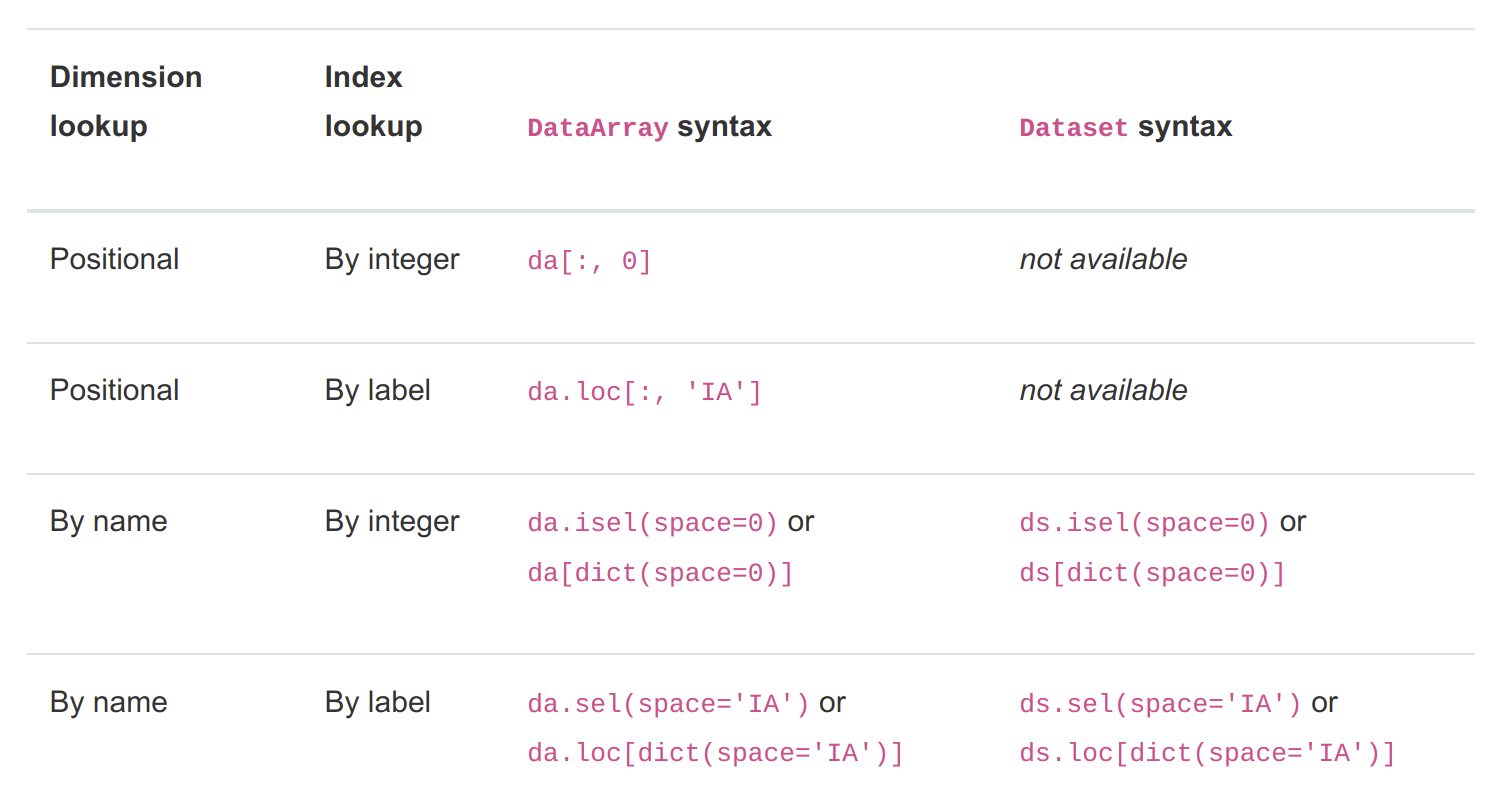

In [145]:
display(Image(filename='Geospatial Analysis in Python/figures/xarray_index.png',width=600))

Since `xarray` objects are analogous to Pandas DataFrames, we can use either **labels** _or_ **integers** (0 based indexing) to access or slice/dice data.

### A. Access a single value

The following code extracts the **information from the indices that you specify** - i.e., it tells you what the latitude, level, longitude, and time correspond to the 0th, 0th, 90th, and 100th positions.

Note that you must specify the indices _in the order that they are written_.

In [57]:
temp[0, 0, 90, 100]

<xarray.DataArray 'temp' ()>
[1 values with dtype=float32]
Coordinates:
    latc     float64 49.9
    level    float64 1.0
    lonc     float64 -9.5
    time     datetime64[ns] 1996-02-01T01:00:00
Attributes:
    units:        degC
    long_name:    temperature
    valid_range:  [-2. 40.]

### <span style="color:darkred"> A quick aside on lazy loading:
    
By default, `xarray` uses "lazy loading".
    
This means that when you access the values using the syntax above, `xarray` only **displays to you what the data will look like**, but **without actually loading the data into your workspace.** (This is done to save time and memory - useful when exploring enormous amounts of data).

For example, when we **index** a value, we **can't actually see what value** it has.

In [63]:
temp[0, 0, 90, 100]

<xarray.DataArray 'temp' ()>
[1 values with dtype=float32]
Coordinates:
    latc     float64 45.4
    level    float64 1.0
    lonc     float64 -17.5
    time     datetime64[ns] 1996-02-01T01:00:00
Attributes:
    units:        degC
    long_name:    temperature
    valid_range:  [-2. 40.]

To actually **access the actual values of data**, we actually need to **use the `.values` method**.

`.values` loads the **specific values that we index**:

In [66]:
temp[0, 0, 90, 100].values

array(11.532867, dtype=float32)

Alternatively, you can also **call the `.load()` method** on the entire variable to load the whole thing:

In [ ]:
temp.load()

If you call `load()` on the variable, then you don't have to use `.values` anymore because **all the values in `temp`, including all of the coordinates**, are now in your workspace.

### B. Slicing and Dicing Data

Slicing and dicing data refer to accessing multiple values at once. This is useful because often you may just want to analyze one or two of the total dimensions you have, or a subset of certain dimensions.

<br>
<img src='https://blog.trginternational.com/hs-fs/hubfs/images/Slicing-and-Dicing.jpg?width=1422&name=Slicing-and-Dicing.jpg' style="width:400px";/>

For example, maybe you want to plot all the latitude and longitude points for a variable, but only at a single time point. That would be represented by the <span style="color:orange">orange</span> or <span style="color:red">red</span> _slices_ in the below figure.

<br>
<img src="https://docs.digitalearthafrica.org/en/latest/_images/dataset-diagram.png" style="width:600px";/>

Note that often **it is very useful to look at the shape of the data** you are slicing or dicing to make sure you are extracting the correct parts of the data. Can you guess the shape of each slice of data below?

In [30]:
# positional by integer
print(temp[0, 2, :, :].shape)

# positional by label
print(temp.loc['1996-02-02T01:00:00', :, :, :].shape)

# by name and integer
print(temp.isel(level=1, latc=90, lonc=100).shape)

# by name and label
print(temp.sel(time='1996-02-02T01:00:00').shape)

You can also **select data using the nearest value** using the `.sel()` method. This is very useful if you have multiple geospatial datasets at differing resolutions.

In [ ]:
GETM['temp'].sel(level=2, lonc=-5.0, latc=50.0, method='nearest')

In [ ]:
# Use tolerance for label selection (lat=-50 should not yield data)
tol = 0.5

try:
    GETM['temp'].sel(level=1, lonc=-5.0, latc=-50.0, method='nearest', tolerance=tol)
except KeyError:
    print(f'ERROR: outside tolerance of {tol}')

## Statistical Analysis and Mathematical Operations

`xarray` also makes it very easy to do statistical analysis across different dimensions of your data.

You can do basic mathematical operations, like **add, subtract, multiply, divide, exponentiate, or log** your data:

In [73]:
temp.loc['1996-02-06T01:00:00.00', :, :, :]-temp.loc['1996-02-02T01:00:00', :, :, :]

In [76]:
np.exp(temp.loc['1996-02-06T01:00:00.00', :, :, :])

Similar to NumPy and Pandas, `xarray` also supports **statistical functions such as `mean()`, `median()`, `std()`, `quantile()`, etc.**

For example, say you wanted to **take the mean across all of the time slices in the `temp` data**.

Similar to how you might specify an axis in NumPy, you **specify the dimension across which to take the mean** using the `dim` keyword argument:

In [31]:
temp.mean(dim='time')

Like in Pandas, you can also use the **`groupby()` function to group your data.**

In [35]:
temp.groupby('level')

DataArrayGroupBy, grouped over 'level'
5 groups with labels 1.0, 6.0, 11.0, 16.0, 21.0.

In [78]:
temp.groupby('time.day')

DataArrayGroupBy, grouped over 'day'
6 groups with labels 1, 2, 3, 4, 5, 6.

You can access a group like so:

In [38]:
temp.groupby('level')[1.0]

<xarray.DataArray 'temp' (time: 6, latc: 360, lonc: 396)>
array([[[nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan],
        ...,
        [nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan]],

       [[nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan],
        ...,
        [nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan]],

       ...,

       [[nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan],
        ...,
        [nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan]],

       [[nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan],
        ...,
        [nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan]]], dtype=float32)
Coordinates:
  * latc     (latc) float64 45.4 45.45 45.5 45.55 45.6 ... 63.2 63.25 63.3 63.35
    level    float64 1.0
  * lonc     (lonc) float64 -17.5 -17.42 -17.34 -17.26 ... 13.94 14.02 14.1
  * time     (time) datetime64[ns] 1996-02-01T01:00:00 ... 1996-02-06T01:00:00
Attributes:
    units:        degC
    long_name:    temperature
    valid_range:  [-2. 40.]

You can then calculate statistics for each of those different groups. For example, if you wanted to **calculate the mean across all the time slices** for **each level**, you would write:

In [79]:
temp.groupby('level').mean(dim='time')

* The first part `temp.groupby('level')` groups the data by levels.
* The second part `.mean(dim='time')` takes the mean across the `time` dimension for each of the groups.

What shape would each group have?

## Quick Plotting

Note that you can also use the built-in **`xarray` plotting method `.plot()`** as a **quick way to visualize your data**. However, adding the different map specifications (e.g., projection, coastlines) will be more difficult without going the "long way", which we will cover in the demo below.

In the example below, we will find the **temperature difference** between the **highest and lowest depth layers** in our dataset.

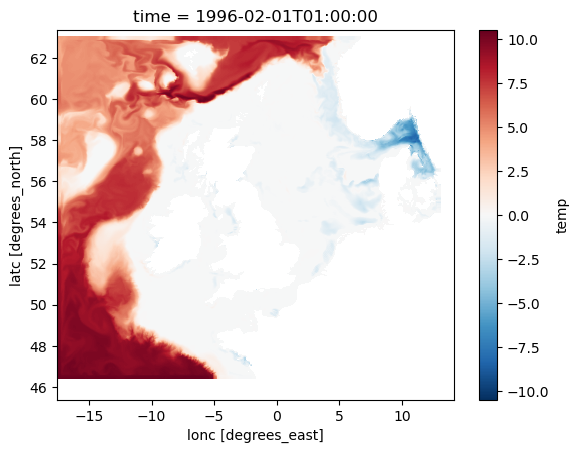

In [91]:
# Slice the data from the top and bottom layers...what shape will these slices have?
top = GETM['temp'].isel(time=0, level=4)
bottom = GETM['temp'].isel(time=0, level=0)

# Calculate the difference between the two layers
diff = top - bottom

# Plot the data
diff.plot()

When performing mathematical operations on Datasets (or any data structure, really), **what must be true about the <u>shape</u> of the two Datasets?**

### Calculations along a dimension

In the example below, we will calculate the **average temperature** over the **time** and **level** dimensions.

#### **i.** Average temperature over all time points

* What shape will `time_ave` have? Why does it have this shape?
* Plot `time_ave`. Why does the plot look the way it does? What dimensions do you think are being plotted?

In [93]:
# Calculate average temperature over all time
time_ave = GETM['temp'].mean('time')

time_ave.plot()

#### **ii.** Average temperature over all time points and all vertical levels
* What shape will `time_and_level_ave` have? Why does it have this shape?
* Plot `time_and_level_ave`. What dimensions are being plotted?

In [55]:
# Calculate average temperature over time and all levels
time_and_level_ave = GETM['temp'].mean(['time','level'])

time_and_level_ave.plot()

#### **iii.** Average temperature over all time points and all longitude points
* What shape will `timelon_ave` have? Why does it have this shape?
* Plot `timelon_ave`. Why isn't the plot a map? What dimensions are being plotted?

In [66]:
# Calculate zonal average for single vertical layer
timelon_ave = GETM['temp'].mean(['time','lonc']).isel(level=4)

timelon_ave.plot()

## Importing and Appending Multiple File Datasets

A very useful function in `xarray` is the **`open_mfdataset()`, or "open multi-file dataset"**.

This function allows you to **open multiple files as a single, concatenated dataset**. This is very useful if you are working with data that has been split into many files, such as time series, where there is a file for each time increment.
* Note that this function generally **requires that all the files have a similar format**- e.g., same variables, same coordinates, same shape, etc. - depending on what dimension you are concatenating.

For example, say you have **daily temperature data the first 7 days of December 2023**. You would like to open this as a single dataset. Here we use the `glob` package and function to grab all of our files using Linux-like syntax:

In [3]:
T_files = glob.glob('Geospatial Analysis in Python/data/T2m/*')
T_files

['data/T2m\\T2m_ERA5_20231201_daily_mean_max.nc',
 'data/T2m\\T2m_ERA5_20231202_daily_mean_max.nc',
 'data/T2m\\T2m_ERA5_20231203_daily_mean_max.nc',
 'data/T2m\\T2m_ERA5_20231204_daily_mean_max.nc',
 'data/T2m\\T2m_ERA5_20231205_daily_mean_max.nc',
 'data/T2m\\T2m_ERA5_20231206_daily_mean_max.nc',
 'data/T2m\\T2m_ERA5_20231207_daily_mean_max.nc']

To open all of these files to the same variable, you would type:

In [4]:
T2m = xr.open_mfdataset(T_files,concat_dim='time',combine='nested')
T2m

<xarray.Dataset>
Dimensions:  (lat: 721, lon: 1440, time: 7)
Coordinates:
  * lat      (lat) float32 90.0 89.75 89.5 89.25 ... -89.25 -89.5 -89.75 -90.0
  * lon      (lon) float32 0.0 0.25 0.5 0.75 1.0 ... 359.0 359.2 359.5 359.8
Dimensions without coordinates: time
Data variables:
    T_max    (time, lat, lon) float64 dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
    T_mean   (time, lat, lon) float64 dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
Attributes:
    creator:      Alice Hsu
    description:  Daily mean and maximum 2 meter temperature from ERA5 data; ...

* The `concat_dim='time'` tells `xarray` to create a new dimension, `time`, along which to concatenate the files.
* The `combine='nested'` is the method it uses to concatenate the data.
    * (The two options are [`nested`](https://docs.xarray.dev/en/stable/generated/xarray.combine_nested.html) or [`coords`](https://docs.xarray.dev/en/latest/generated/xarray.combine_by_coords.html) - click the documentation to learn more about each.)

Note that since we created the `time` dimension (i.e., it wasn't in the original file), we can **set the values** we want it to be so that it is more descriptive.

By default, the dimension we concatenated on just has positional indices as its values:

In [5]:
T2m['time']

<xarray.DataArray 'time' (time: 7)>
array([0, 1, 2, 3, 4, 5, 6], dtype=int64)
Dimensions without coordinates: time

Here, we will set `time` to be a Pandas `datetime` object.

In [6]:
T2m['time'] = pd.date_range('20231201','20231207')

`datetime` objects have useful properties we can exploit. For example, you can extract the **day, month, year, day of year**, and more attributes from a `datetime` array:

In [7]:
pd.date_range('20231201','20231207').day

Index([1, 2, 3, 4, 5, 6, 7], dtype='int32')

In [8]:
pd.date_range('20231201','20231207').dayofyear

Index([335, 336, 337, 338, 339, 340, 341], dtype='int32')

These attributes come in very handy when doing statistical analysis, because you can **group data by these attributes**.

In [9]:
T2m.groupby('time.dayofyear')

DatasetGroupBy, grouped over 'dayofyear'
7 groups with labels 335, 336, 337, 338, 339, 340, 341.

You can then perform **statistical analysis on each of these groups**:

In [53]:
T2m.groupby('time.dayofyear').mean()

# Plotting

# DEMO: Plotting `xarray` data in the North Sea
In this exercise, we will practice accessing, slicing, and plotting the data from the North Sea SST dataset using `xarray`, `matplotlib`, and `cartopy`.

In [31]:
%matplotlib inline
import matplotlib.pyplot as plt
import cartopy

We are going to make a 1x3 grid of maps, of each of the variables in the `GETM` Dataset:

1. All plots will **show data from February 6, 1996.**
1. The **first plot** will be of the **bathymetry, `bathymetry`**.
2. The **second plot** will be of the **height, `h`**, at the **lowest level, 1.0.**
3. The **third plot** will be of the **temperature, `temp`**, **averaged over all levels (`level`)**.
4. All plots will be displayed in the **Stereographic projection**.

Your final figure should look like this:

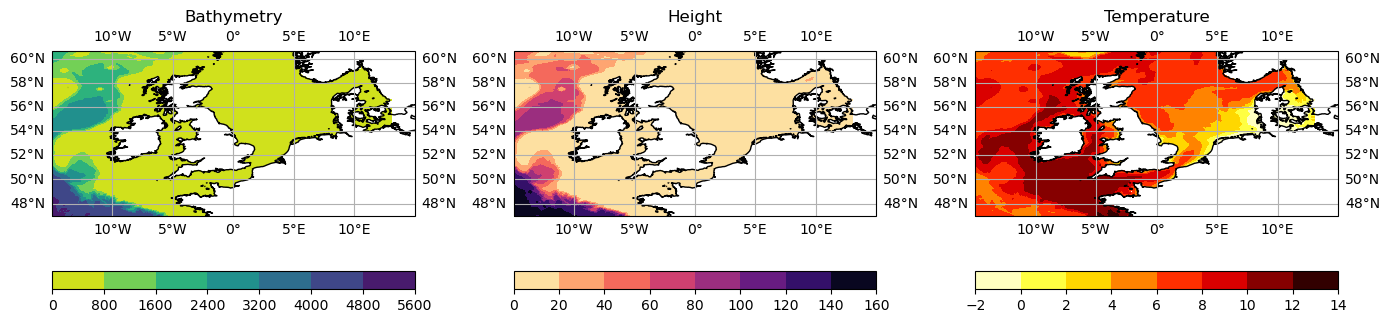

In [142]:
display(Image(filename='Geospatial Analysis in Python/figures/north_sea.png',width=1000))

### Concepts Covered:
* Accessing variables in xarray DataArrays
* Slicing data from variables in DataArrays
* Calculating across dimensions from DataArrays
* Plotting with Cartopy

Let's first start with extracting the **bathymetry data**:

In [53]:
bath_data = GETM['bathymetry']
bath_data

<xarray.DataArray 'bathymetry' (latc: 360, lonc: 396)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * latc     (latc) float64 45.4 45.45 45.5 45.55 45.6 ... 63.2 63.25 63.3 63.35
  * lonc     (lonc) float64 -17.5 -17.42 -17.34 -17.26 ... 13.94 14.02 14.1
Attributes:
    units:        m
    long_name:    bathymetry
    valid_range:  [  -5. 4000.]

Next, let's extract the **height** data. Remember that we only want a subset of the whole height variable - we want the heights at **all latitudes (`latc`) and longitudes (`lonc`)**, but **only when the `level` is 1.0**, and when the **date is February 6, 1996**.

In [54]:
h_data = GETM['h'].sel(level=1.0,time='1996-02-06T01:00:00.000000000')
h_data

<xarray.DataArray 'h' (latc: 360, lonc: 396)>
[142560 values with dtype=float32]
Coordinates:
  * latc     (latc) float64 45.4 45.45 45.5 45.55 45.6 ... 63.2 63.25 63.3 63.35
    level    float64 1.0
  * lonc     (lonc) float64 -17.5 -17.42 -17.34 -17.26 ... 13.94 14.02 14.1
    time     datetime64[ns] 1996-02-06T01:00:00
Attributes:
    units:      m
    long_name:  layer thickness

Lastly, let's extract the **temperature** data. Similar to the height, we want all temperatures at **all latitudes (`latc`) and longitudes (`lonc`)**, but **averaged over all levels**, and when the **date is February 6, 1996**.

In [55]:
temp_data = GETM['temp'].sel(time='1996-02-06T01:00:00').mean(dim='level')
temp_data

<xarray.DataArray 'temp' (latc: 360, lonc: 396)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)
Coordinates:
  * latc     (latc) float64 45.4 45.45 45.5 45.55 45.6 ... 63.2 63.25 63.3 63.35
  * lonc     (lonc) float64 -17.5 -17.42 -17.34 -17.26 ... 13.94 14.02 14.1
    time     datetime64[ns] 1996-02-06T01:00:00

In [67]:
GETM['temp']

<xarray.DataArray 'temp' (time: 6, level: 5, latc: 360, lonc: 396)>
[4276800 values with dtype=float32]
Coordinates:
  * latc     (latc) float64 45.4 45.45 45.5 45.55 45.6 ... 63.2 63.25 63.3 63.35
  * level    (level) float64 1.0 6.0 11.0 16.0 21.0
  * lonc     (lonc) float64 -17.5 -17.42 -17.34 -17.26 ... 13.94 14.02 14.1
  * time     (time) datetime64[ns] 1996-02-01T01:00:00 ... 1996-02-06T01:00:00
Attributes:
    units:        degC
    long_name:    temperature
    valid_range:  [-2. 40.]

Now that we've extracted the variables we want to plot, let's now **set up the coordinates (i.e., latitudes and longitudes)** that we're plotting along:

In [56]:
# Extract the latitude and longitude values
latc = GETM['latc']
lonc = GETM['lonc']

Now we're ready to create our plot! The following steps will walk us through the plotting:

* Create a **CRS object** called **`plot_CRS`** for the CRS we want to want to create the plot in.
* Create the **figure and subplots.**
    * Use the `fig,ax = plt.subplots()` to make the figure and subplots.
        * To set the projection of all these subplots, you will have to specify the keyword argument as a dictionary:
        * `subplot_kw={'projection':plot_crs}`
    * Set your **figure size (`figsize`)** equal to (14,4) to make your figure more readable.
* **Add coastlines** to the figure.
* **Set the extent** of the axes so that the **longitude goes from -15 to 15 degrees**, and the **latitude from 47 to 60 degrees**.
* **Add the bathymetry data** to a `contourf()`.
    * Set the **colormap keyword argument (`cmap`)** to `'viridis_r'`.
* **Add the height data** to a `contourf()`.
    * Set the **colormap keyword argument (`cmap`)** to `'magma'`.
* **Add the temperature data** to a `contourf()`.
    * Set the **colormap keyword argument (`cmap`)** to `'hot_r'`.
* Add a **colorbar** to **each subplot**.
    * Set the **location (`location`)** of the colorbar to `'bottom'`.
* Set a **title** for **each subplot**.

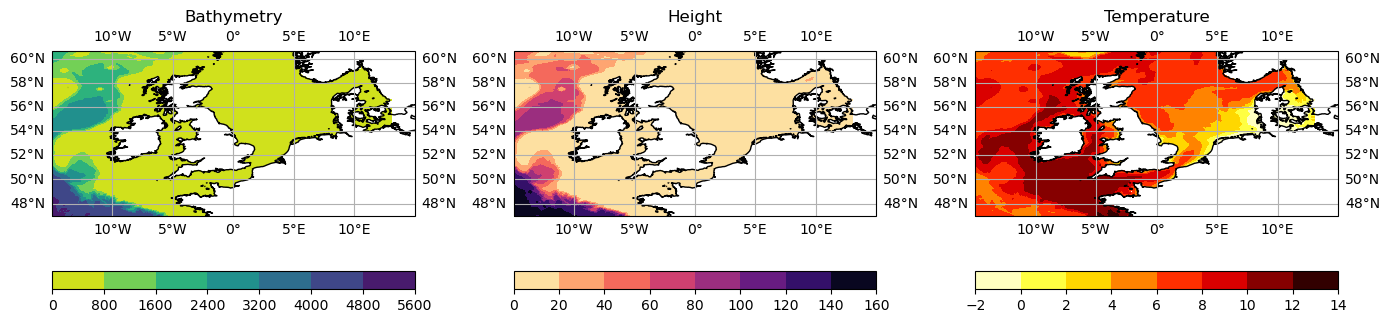

In [88]:
plot_crs = cartopy.crs.PlateCarree()
fig,ax = plt.subplots(1,3,figsize=(14,4),subplot_kw={'projection':plot_crs},sharex=True)

# Create the map figure with our desired features using the function we defined above
ax[0].coastlines()
ax[1].coastlines()
ax[2].coastlines()

ax[0].set_extent([-15, 15, 47, 60])
ax[1].set_extent([-15, 15, 47, 60])
ax[2].set_extent([-15, 15, 47, 60])

ax[0].gridlines(draw_labels=True)
ax[1].gridlines(draw_labels=True)
ax[2].gridlines(draw_labels=True)

# Actually plot our sliced netCDF data onto the map we made
cm0 = ax[0].contourf(lonc, latc, bath_data, cmap='viridis_r')
cm1 = ax[1].contourf(lonc, latc, h_data, cmap='magma_r')
cm2 = ax[2].contourf(lonc, latc, temp_data, cmap='hot_r')

# Add a colorbar
cbar0 = fig.colorbar(cm0,location='bottom')
cbar1 = fig.colorbar(cm1,location='bottom')
cbar2 = fig.colorbar(cm2,location='bottom')

# Add a title
ax[0].set_title('Bathymetry');
ax[1].set_title('Height');
ax[2].set_title('Temperature');
plt.tight_layout()

## 4. Saving Datasets to a netCDF file

`xarray Datasets` can easily be saved as new netCDF files.

In the example below, we will save the temperature averages we calculate into a new netCDF file.

In [69]:
# Calculate the average temperature across all time points and all vertical levels
ds = GETM['temp'].mean(['time','level']) # what shape will ds have?

# Save data slice as its own netCDF file
ds.to_netcdf('Geospatial Analysis in Python/data/temp_avg_level_time.nc')

## 5. Import remote dataset

`xarray` supports [OpenDAP](https://www.opendap.org/). This means that a dataset can be accessed remotely and subsetted as needed. Only the selected parts are downloaded.

In [ ]:
remote_data = xr.open_dataset(
      'http://iridl.ldeo.columbia.edu/SOURCES/.OSU/.PRISM/.monthly/dods',
      decode_times=False)
remote_data

***

# Practical: Plotting Global Land Temperatures

In this exercise, you are going to plot the 2-meter temperature multi-file dataset that we opened using the `xr.open_mfdataset()`.

Recall that each of these files contains two variables:
* The daily mean temperature, `T_mean`
* The daily maximum temperature, `T_max`.

In this exercise, you will make **3 plots**:
* **Daily mean temperatures** averaged across the whole week
* **Daily maximum temperatures** averaged across the whole week
* The **difference between the daily mean and maximum temperatures**, averaged across the whole week

Some code to get you started:

In [ ]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import xarray as xr

In [130]:
T_files = glob.glob('Geospatial Analysis in Python/data/T2m/*')
T2m = xr.open_mfdataset(T_files,concat_dim='time',combine='nested')
# Convert longitude from 0 to 360 to -180 to 180
T2m = T2m.roll(lon=720)
T2m['lon'] = T2m['lon']-180

First, access the **daily mean temperature (`'T_mean'`)** and **daily max temperature (`'T_max'`)** from the `T2m` variables and save them as variables called **`Tmean` and `Tmax`**, respectively.

In [131]:
### YOUR CODE HERE ###



Take the **average of `Tmean` and `Tmax` across the whole time period** and **save them as variables called `Tmean_wk` and `Tmax_wk`.**

In [132]:
### YOUR CODE HERE ###



Take the **difference between the `Tmax_wk` and `Tmean_wk`** and **save it as a variable called `Tdif_wk`.**

In [133]:
### YOUR CODE HERE ###


Extract the **latitudes and longitudes** of the data **from `T2m`**.

In [135]:
### YOUR CODE HERE ###



Now we can create a plot of our datasets.
1. Create a **CRS object** called **`plot_CRS`** for the CRS we want to want to create the plot in.
    * Use the Plate Carree projection.
1. Create the **figure and axes** using `fig,ax = plt.subplots()`.
    * Set the **figure size** to (14,4).
    * Set the **projection** to `plot_CRS`.
2. Add **coastlines** to each of the subplots.
3. Add the **data** to the subplots using **`contourf()`**.
4. Add **titles** to each of the subplots.

Text(0.5, 1.0, 'Tdif')

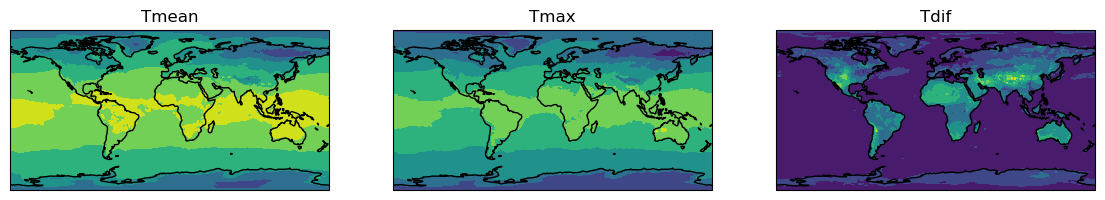

In [138]:
### YOUR CODE HERE ###







## References

* https://www.unidata.ucar.edu/software/netcdf/docs/netcdf_data_model.html
* http://xarray.pydata.org/en/stable/getting-started-guide/quick-overview.html#indexing

# Course Evaluation: Please fill out [this quick eval!](https://forms.office.com/Pages/ResponsePage.aspx?id=lYdfxj26UUOKBwhl5djwkFtIujJ9lCFMouysTWFV3rRURFZHRjFZUVc2QTlJNzJDMUdUWjhXN1dPMi4u)